[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1DSSHN_lRd0A_tPBwYBi6zlOd_9N1DBJ3#scrollTo=dpz7yKFTYXPZ)

## HW Requirement

• Rewrite the best code (of the weight-tuning_EB
referring to page 14) you have for HW #1 into 
the code of the weight-tuning_LG. Best means the 
best hyperparameter setting.


• Rewrite the best code (of the weight-tuning_EB
referring to page 14) you have for HW #1 into 
the code of the weight-tuning_EB_LG.


• Once you have the code, you will apply the code 
to learn your dataset for HW #1.


• The training and test dataset is 80%/20%.


• The performance comparison benchmark is your 
best weight-tuning_EB.

Model 6 \
hidden nodes: 11 \
epochs: 300 \
init: xavier \
active: relu \
optimize: sgd \
schedule: None \
weight decay: 0.0

Model Accuracy: 82.17% \
Training Time: 639.923 s \
Epoch with hightest Train accuracy: 292, 86.19% \
Epoch with hightest Val accuracy= 249, 83.83%

## Model

In [1]:
import torch
from torch import nn, optim, Generator
from torch.utils.data import DataLoader, Dataset, random_split
import sys
import pandas as pd
import cProfile
import pstats


c:\VS_Workplace\NN\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from typing import Iterable, Callable, Type
from operator import mul


def product(nums: Iterable[Type], func: Callable[[Type, Type], Type] = mul):
    def _product(nums):
        nonlocal func
        if len(nums) == 1:
            return nums[0]
        return func(nums[-1], _product(nums[:-1]))
    try:
        return _product(nums)
    except Exception as e:
        raise e


In [3]:
from collections.abc import Callable


class TwoLayerNetwork(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_classes: int, init_method: Callable, active_func: nn.modules.module.Module) -> None:
        super(TwoLayerNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # first layer
        self.fc1 = nn.Linear(input_size, hidden_size)
        # activation
        self.active_func = active_func()
        # initialize
        for param in self.parameters():
            init_method(param)
        # second layer
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.active_func(out)
        out = self.fc2(out)
        return out


In [4]:
from array import array


def train(model: TwoLayerNetwork, opt: nn.Module, device: str, epochs: int, learning_rate: float, trainloader: DataLoader, valloader: DataLoader, criterion: nn.modules.loss._Loss, sched: optim.lr_scheduler._LRScheduler, weight_decay: float, learning_goal: float):
    """
    Args:
        learning goal: the desire ratio of [validation loss / initiate validation loss] to early stop
    """
    if epochs < 1:
        raise ValueError("Invalid epoch!!")
    else:
        epochs = int(epochs)
    model.to(device)
    optimizer = opt(model.parameters(), lr=learning_rate,
                    weight_decay=weight_decay)
    scheduler = sched(optimizer) if sched else None
    history = tuple(array("d", [0] * epochs) for e in range(4))
    # Train the model
    for epoch in range(epochs):
        train_loss = 0.0
        train_correct = 0
        model.train()
        for X, y in trainloader:
            X = X.view(-1, model.input_size).to(device)
            y = y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == y).sum().item()
        train_loss /= len(trainloader.dataset)
        train_accuracy = train_correct / len(trainloader.dataset)

        # Validate the model
        val_loss = 0.0
        val_correct = 0
        model.eval()
        with torch.no_grad():
            for X, y in valloader:
                X = X.view(-1, model.input_size).to(device)
                y = y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item() * X.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == y).sum().item()
            val_loss /= len(valloader.dataset)
            val_accuracy = val_correct / len(valloader.dataset)
        if scheduler:
            scheduler.step()
        # Print epoch statistics
        history[0][epoch] = train_loss
        history[1][epoch] = train_accuracy
        history[2][epoch] = val_loss
        history[3][epoch] = val_accuracy
        if learning_goal * history[2][0] > val_loss:
            return history
        # sys.stdout.write('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%, Val Loss: {:.4f}, Val Accuracy: {:.2f}%\n'
        #       .format(epoch+1, epochs, train_loss, train_accuracy, val_loss, val_accuracy))
    return history


In [5]:
def test(model: nn.Module, device: str, testloader: DataLoader):
    val_correct = 0
    model.to(device)
    model.eval()
    with torch.no_grad():
        for X, y in testloader:
            X = X.view(-1, model.input_size).to(device)
            y = y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == y).sum().item()
        val_accuracy = val_correct / len(testloader.dataset)
    return val_accuracy


# Dataset

### pytorch dataset

In [6]:
# load pytorch dataset

from torchvision import datasets, transforms


def getPytorchData(train: float = 0.8, remain: float = 0.1):
    """
    Args:
        train: train_amount / total_amount or 1 - valid_amount / total_amount
        remain: reduce data amount to save time
    """
    # preprocess: flatten, normalize, drop 90%, split
    transform = transforms.transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    if 0 >= train or train >= 1:
        raise ValueError()
    if 0 > remain or remain > 1:
        raise ValueError()
    # Split the training set into training and validation sets
    trainset = datasets.FashionMNIST(
        root="./data/", train=True, download=False, transform=transform)
    train_count = int(train * remain * len(trainset))
    valid_count = int((1 - train) * remain * len(trainset))
    if train_count * valid_count == 0:
        raise ValueError()
    datum_size = product(trainset[0][0].size())
    class_amount = len(trainset.classes)
    testset = datasets.FashionMNIST(
        root="./data/", train=False, download=False, transform=transform)
    print(train_count, valid_count, len(testset))
    trainset, valset, _ = random_split(
        trainset, (train_count, valid_count, len(trainset) - train_count - valid_count), Generator().manual_seed(42))
    # Create dataloaders to load the data in batches
    trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
    valloader = DataLoader(valset, batch_size=32, shuffle=True)
    testloader = DataLoader(testset, batch_size=32, shuffle=True)
    return trainloader, valloader, testloader, datum_size, class_amount


## Training

### train

In [7]:
device = "cuda" if torch.cuda.is_available(
) else "mps" if torch.backends.mps.is_available() else "cpu"
# hyper parameters
trainloader, valloader, testloader, input_size, output_size = getPytorchData()
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()


4800 1199 10000


### epoch bound

In [8]:
hidden_size = 11
epochs = 300
init = lambda x: nn.init.xavier_uniform_(
    tensor=x) if len(x.shape) > 1 else None
active = nn.ReLU
optimize = optim.SGD
schedule = None
weight_decay = 0.0
learning_goal = 0
model = TwoLayerNetwork(input_size, hidden_size,
                        output_size, init, active)
EB_baseline = test(model, device, testloader)
EB_history = train(model, optimize, device, epochs, learning_rate,
                   trainloader, valloader, criterion, schedule, weight_decay, learning_goal)
EB_result = test(model, device, testloader)
print(EB_baseline, EB_history, EB_result, sep="\n")


0.0876
(array('d', [2.2853939088185626, 2.056309287548065, 1.9088669761021932, 1.776056657632192, 1.6548664776484172, 1.5444618344306946, 1.4461450401941935, 1.3590796979268391, 1.2808109498023987, 1.2098290014266968, 1.1464153520266216, 1.091721518834432, 1.0455641567707061, 1.0060010194778441, 0.97240660349528, 0.9438905572891235, 0.918458612759908, 0.8968089441458384, 0.8774751643339793, 0.8604372270901998, 0.8442367088794708, 0.8306088956197103, 0.8175390430291494, 0.8059681755304337, 0.7950285335381826, 0.784866736928622, 0.7755642237265905, 0.7668179959058762, 0.7584558578332266, 0.751080721616745, 0.7435871829589208, 0.7368040800094604, 0.730350911617279, 0.723767005999883, 0.7184578285614649, 0.7127557279666265, 0.7072050563494364, 0.7019694383939107, 0.6966636262337367, 0.6922221459945043, 0.6872604026397069, 0.6830436482032141, 0.678368926246961, 0.6743212318420411, 0.6699783511956533, 0.665992914835612, 0.6619560209910075, 0.6582261500755946, 0.6540644830465316, 0.6509927590

In [19]:
with open("./data/eb.txt", "w") as f:
    f.write(f"baseline: {EB_baseline}\n")
    for epoch in range(epochs):
        (trn_loss, trn_acc, val_loss, val_acc) = (
            EB_history[0][epoch], EB_history[1][epoch], EB_history[2][epoch], EB_history[3][epoch])
        f.write(
            f"trn_loss: {trn_loss}, trn_acc: {trn_acc}, val_loss: {val_loss}, val_acc: {val_acc}\n")
    f.write(f"result: {EB_result}\n")


### epoch bound and learning goal

In [9]:
hidden_size = 11
epochs = 300


def init(x):
    return nn.init.xavier_uniform_(tensor=x) if len(x.shape) > 1 else None


active = nn.ReLU
optimize = optim.SGD
schedule = None
weight_decay = 0.0
learning_goal = 0.3
model = TwoLayerNetwork(input_size, hidden_size,
                        output_size, init, active)
LG_baseline = test(model, device, testloader)
LG_history = train(model, optimize, device, epochs, learning_rate,
                   trainloader, valloader, criterion, schedule, weight_decay, learning_goal)
LG_result = test(model, device, testloader)
print(LG_baseline, LG_history, LG_result, sep="\n")


0.0918
(array('d', [2.242044480641683, 2.132839250564575, 2.041094032128652, 1.9470709228515626, 1.8518914024035136, 1.7578813791275025, 1.6669762309392293, 1.5769690537452699, 1.4863756497701008, 1.3996202421188355, 1.319681654771169, 1.2461839811007183, 1.1797998468081157, 1.1213753910859425, 1.0694469885031381, 1.0247039409478504, 0.9857806607087454, 0.9519647840658824, 0.9229911740620931, 0.8975288005669911, 0.8749934128920237, 0.855270942846934, 0.8375528033574422, 0.8216395370165507, 0.8077191567420959, 0.7948783377806345, 0.783281392455101, 0.7726930811007817, 0.7629101542631785, 0.7539107513427734, 0.7455135035514832, 0.7371224588155747, 0.7301921377579371, 0.7229599736134211, 0.7167999303340912, 0.7104427458842596, 0.7048309202988943, 0.6992682220538458, 0.6941334325075149, 0.6889248412847518, 0.6841828628381094, 0.6794581971565883, 0.6750515598058701, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [18]:
with open("./data/lg.txt", "w") as f:
    f.write(f"baseline: {LG_baseline}\n")
    for epoch in range(epochs):
        (trn_loss, trn_acc, val_loss, val_acc) = (
            LG_history[0][epoch], LG_history[1][epoch], LG_history[2][epoch], LG_history[3][epoch])
        f.write(
            f"trn_loss: {trn_loss}, trn_acc: {trn_acc}, val_loss: {val_loss}, val_acc: {val_acc}\n")
    f.write(f"result: {LG_result}\n")


### comparison

In [19]:
from matplotlib import pyplot as plt
import re


In [59]:
with open("./data/eb.txt", "r") as f:
    lines = f.readlines()[1:-1]
    EB_history = [[float(e) for e in re.sub(r"[a-z:,_]", " ", l).split()]
                  for l in lines]
print(EB_history)

[[2.2853939088185626, 0.13583333333333333, 2.1245000354442327, 0.21017514595496248], [2.056309287548065, 0.23854166666666668, 1.956686896915929, 0.29357798165137616], [1.9088669761021932, 0.28979166666666667, 1.8127926830652856, 0.3302752293577982], [1.776056657632192, 0.32666666666666666, 1.684830385312326, 0.36447039199332776], [1.6548664776484172, 0.37, 1.568792879929435, 0.41201000834028356], [1.5444618344306946, 0.430625, 1.4648863573289097, 0.49124270225187655], [1.4461450401941935, 0.4970833333333333, 1.3730761582300601, 0.5412844036697247], [1.3590796979268391, 0.5466666666666666, 1.2901228387918544, 0.5779816513761468], [1.2808109498023987, 0.5810416666666667, 1.2158673742197275, 0.6055045871559633], [1.2098290014266968, 0.6027083333333333, 1.1478738183275274, 0.6313594662218516], [1.1464153520266216, 0.6179166666666667, 1.0892318631332054, 0.6547122602168474], [1.091721518834432, 0.6329166666666667, 1.0386332905322337, 0.6555462885738115], [1.0455641567707061, 0.6470833333333

In [40]:
with open("./data/lg.txt", "r") as f:
    lines = f.readlines()[1:-1]
    LG_history = [[float(e) for e in re.sub(
        r"[a-z:,_]", " ", l).split()] for l in lines]
print(LG_history)


[[2.242044480641683, 0.135, 2.168122190152535, 0.19349457881567975], [2.132839250564575, 0.21604166666666666, 2.0714216083163914, 0.2610508757297748], [2.041094032128652, 0.300625, 1.9757205537202658, 0.34361968306922436], [1.9470709228515626, 0.35833333333333334, 1.87736032683219, 0.371976647206005], [1.8518914024035136, 0.3877083333333333, 1.7799906245463086, 0.3894912427022519], [1.7578813791275025, 0.4058333333333333, 1.685817721985697, 0.41117597998331945], [1.6669762309392293, 0.441875, 1.5964284402514817, 0.46788990825688076], [1.5769690537452699, 0.48791666666666667, 1.5075346778292176, 0.5162635529608006], [1.4863756497701008, 0.5229166666666667, 1.418467953863295, 0.554628857381151], [1.3996202421188355, 0.5554166666666667, 1.3360621028387913, 0.5879899916597164], [1.319681654771169, 0.59375, 1.2600824749400161, 0.6205170975813178], [1.2461839811007183, 0.6220833333333333, 1.1892047919662323, 0.6447039199332777], [1.1797998468081157, 0.643125, 1.127606140065929, 0.66305254378

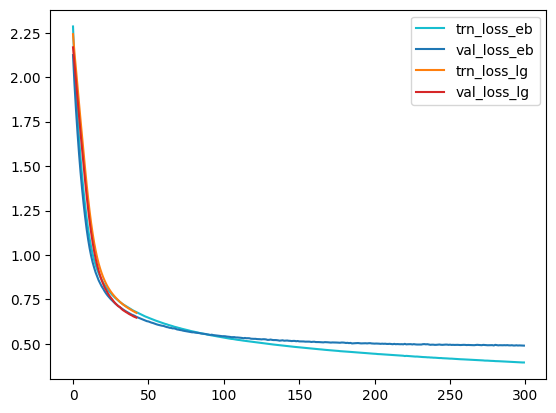

In [56]:
x = range(300)
x1 = range(len([_ for e in LG_history if e[0] != 0.0 and e[2] != 0.0]))
plt.plot(x, [e[0] for e in EB_history], "tab:cyan", label="trn_loss_eb")
plt.plot(x, [e[2] for e in EB_history], "tab:blue", label="val_loss_eb")
plt.plot(x1, [e[0] for e in LG_history if e[0] != 0.0], "tab:orange", label="trn_loss_lg")
plt.plot(x1, [e[2] for e in LG_history if e[2] != 0.0], "tab:red", label="val_loss_lg")
plt.legend(loc="upper right")
plt.show()


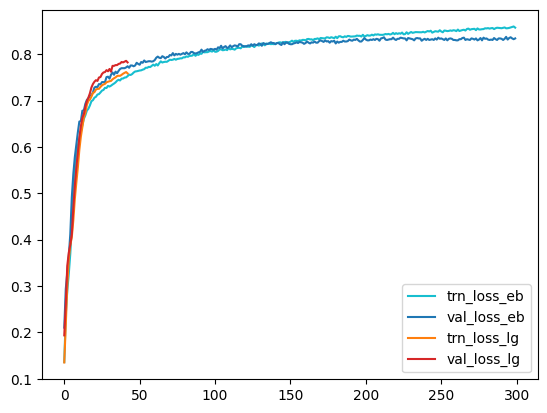

In [58]:
x = range(300)
x2 = range(len([_ for e in LG_history if e[1] != 0.0 and e[3] != 0.0]))
plt.plot(x, [e[1] for e in EB_history], "tab:cyan", label="trn_loss_eb")
plt.plot(x, [e[3] for e in EB_history], "tab:blue", label="val_loss_eb")
plt.plot(x2, [e[1] for e in LG_history if e[1] != 0.0], "tab:orange", label="trn_loss_lg")
plt.plot(x2, [e[3] for e in LG_history if e[3] != 0.0], "tab:red", label="val_loss_lg")
plt.legend(loc="lower right")
plt.show()
